In [100]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [101]:
import numpy as np
import pandas as pd

In [102]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [103]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [104]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [105]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [106]:
# We can view all of the classes that automap found
Base.classes.keys()

[&#39;measurement&#39;, &#39;station&#39;]

In [107]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [108]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [109]:
# Inspecting dictionary keys
frow_station = session.query(Station).first()
frow_station.__dict__

{&#39;_sa_instance_state&#39;: &lt;sqlalchemy.orm.state.InstanceState at 0x196326f1860&gt;,
 &#39;elevation&#39;: 3.0,
 &#39;latitude&#39;: 21.2716,
 &#39;longitude&#39;: -157.8168,
 &#39;name&#39;: &#39;WAIKIKI 717.2, HI US&#39;,
 &#39;station&#39;: &#39;USC00519397&#39;,
 &#39;id&#39;: 1}

In [110]:
# Inspecting dictionary keys
frow_measurement = session.query(Measurement).first()
frow_measurement.__dict__

{&#39;_sa_instance_state&#39;: &lt;sqlalchemy.orm.state.InstanceState at 0x196326f12e8&gt;,
 &#39;station&#39;: &#39;USC00519397&#39;,
 &#39;tobs&#39;: 65.0,
 &#39;date&#39;: &#39;2010-01-01&#39;,
 &#39;id&#39;: 1,
 &#39;prcp&#39;: 0.08}

In [111]:
# Find most recent date in the data set
from sqlalchemy import desc
date_query = session.query(Measurement).filter(Measurement.date).order_by(desc(Measurement.date)).first()
date_query.__dict__

{&#39;_sa_instance_state&#39;: &lt;sqlalchemy.orm.state.InstanceState at 0x196326f5080&gt;,
 &#39;station&#39;: &#39;USC00519397&#39;,
 &#39;tobs&#39;: 81.0,
 &#39;date&#39;: &#39;2017-08-23&#39;,
 &#39;id&#39;: 2724,
 &#39;prcp&#39;: 0.0}

In [112]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database
date = dt.date(2017,8,23) - dt.timedelta(days=365)
prcp = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= date).group_by(Measurement.date).all()


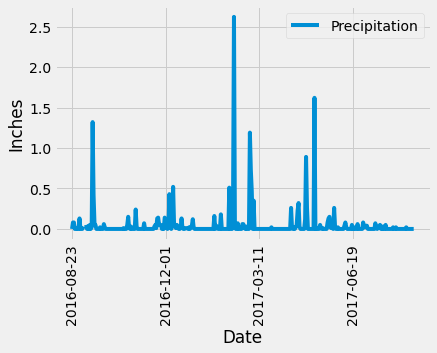

In [42]:
# Perform a query to retrieve the data and precipitation scores
# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_df = pd.DataFrame(prcp)
prcp_df = prcp_df.rename(columns={"date":"Date", "prcp": "Precipitation"}).set_index("Date")


# Sort the dataframe by date
prcp_df = prcp_df.sort_values("Date")

# Use Pandas Plotting with Matplotlib to plot the data
prcp_df.plot(rot=90)
plt.xlabel("Date")
plt.ylabel("Inches")
plt.show()

In [113]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_df.describe()

,Precipitation
count,364.000000
mean,0.048709
std,0.204930
min,0.000000
25%,0.000000
50%,0.000000
75%,0.020000
max,2.620000


In [114]:
# Design a query to show how many stations are available in this dataset?
session.query(Station.station).count()

9

In [148]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
station_query = session.query(Measurement.station,
    func.count(Measurement.station).label('station')
    ).group_by(Measurement.station
    ).order_by(desc('station')).all()
station_query

[(&#39;USC00519281&#39;, 2772),
 (&#39;USC00519397&#39;, 2724),
 (&#39;USC00513117&#39;, 2709),
 (&#39;USC00519523&#39;, 2669),
 (&#39;USC00516128&#39;, 2612),
 (&#39;USC00514830&#39;, 2202),
 (&#39;USC00511918&#39;, 1979),
 (&#39;USC00517948&#39;, 1372),
 (&#39;USC00518838&#39;, 511)]

In [182]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
lowest_temp_query = session.query(Measurement.station, Measurement.tobs
    ).filter(Measurement.station == 'USC00519281'
    ).order_by(("tobs")).first()[1]

highest_temp_query = session.query(Measurement.station, Measurement.tobs
    ).filter(Measurement.station == 'USC00519281'
    ).order_by(desc("tobs")).first()[1]

average_temp_query = round(session.query(Measurement.station, Measurement.tobs,
    func.avg(Measurement.tobs).label('average')
    ).filter(Measurement.station == 'USC00519281'
    ).all()[0][2], 2)

print(f'''
Minimum Temperature: {lowest_temp_query}
Maximum Temperature: {highest_temp_query}
Average Temperature: {average_temp_query} ''')



Minimum Temperature: 54.0
Maximum Temperature: 85.0
Average Temperature: 71.66 


(array([ 5.,  7.,  7., 12., 27., 41., 40., 57., 66., 53., 29.,  8.]),
 array([59., 61., 63., 65., 67., 69., 71., 73., 75., 77., 79., 81., 83.]),
 &lt;a list of 12 Patch objects&gt;)

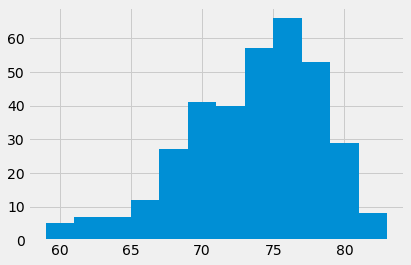

In [191]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
date = dt.date(2017,8,23) - dt.timedelta(days=365)
temp_observations_query = session.query(Measurement.station, Measurement.date, Measurement.tobs
    ).filter(Measurement.station == 'USC00519281'
    ).filter(Measurement.date >= date).group_by(Measurement.date).all()

temp_observations_df = pd.DataFrame(temp_observations_query)
plt.hist(temp_observations_df["tobs"], bins = 12)

## Bonus Challenge Assignment

In [ ]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
